In [1]:
import sccellfie
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

import json
import textwrap

from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import mpl_fontkit as fk
fk.install("Lato")
fk.set_font("Lato")

Font name: `Lato`


## Load data

In [4]:
adata = sc.read_h5ad('/nfs/team292/eg22/Datasets/Endometrium/endometriumAtlasV2_cells_with_counts.h5ad', backed='r')

**Filter for Control cells**

In [5]:
adata.obs['Endometrial_pathology'].unique()

['C', 'E', 'E + F', 'E + A', 'E + A + F']
Categories (5, object): ['C', 'E', 'E + A', 'E + A + F', 'E + F']

In [6]:
adata.obs['Endometriosis'] = adata.obs['Endometrial_pathology'].apply(lambda x: 'Endometriosis' if x != 'C' else 'Control')
adata.obs['E_celltype'] = adata.obs['Endometriosis'].astype(str) + ' - ' + adata.obs['celltype'].astype(str)

In [7]:
barcodes = adata.obs[adata.obs['Endometriosis'] == 'Control'].index.tolist()

In [8]:
len(barcodes)

168434

**Open scCellFie precomputed outputs**

In [9]:
with open('./MT-2025-02-18/cell_type_mapping.json', mode='r') as fp:
    cell_dict = json.load(fp)

In [10]:
cells = cell_dict.keys()

In [11]:
for i, ct in tqdm(enumerate(cells), total=len(cells)):
    mt_df = pd.read_csv('./MT-2025-02-18/MT_dataframe_{}.csv'.format(cell_dict[ct]), index_col=0)
    if i == 0:
        mt_adata = sc.AnnData(X=mt_df, obs=adata[mt_df.index].obs)
    else:
        mt_adata = ad.concat([mt_adata, sc.AnnData(X=mt_df, obs=adata[mt_df.index].obs)], join="outer")

100%|██████████| 36/36 [00:33<00:00,  1.07it/s]


In [12]:
mt_adata.X[np.isnan(mt_adata.X)] = 0

**Apply filter of control cells**

In [13]:
mt_adata = mt_adata[barcodes]

In [14]:
mt_adata.shape

(168434, 215)

In [15]:
adata = adata[barcodes].to_memory()

In [16]:
mt_adata.uns = adata.uns

In [17]:
mt_adata.obsm = adata.obsm

In [18]:
mt_adata

AnnData object with n_obs × n_vars = 168434 × 215
    obs: 'n_genes', 'sample', 'library', 'Processing', 'Treatment', '10x kit', 'percent_mito', 'n_counts', 'scrublet_score', 'genotype', 'Library_genotype', 'Group', 'Endometriosis_stage', 'Hormonal treatment', 'Binary Stage', 'Stage', 'phase', 'dataset', 'Biopsy_type', 'Tissue_sampled', 'Age', 'Endometrial_pathology', 'celltype', 'lineage', 'label_long', 'Endometriosis', 'E_celltype'
    uns: 'Binary Stage_colors', 'Biopsy_type_colors', 'Endometrial_pathology_colors', 'Endometriosis_stage_colors', 'GarciaAlonso_celltype_colors', 'Group_colors', 'Hormonal treatment_colors', 'Library_genotype_colors', 'Mareckova_celltype_colors', 'Mareckova_epi_celltype_colors', 'Mareckova_lineage_colors', 'Processing_colors', 'Symbol_colors', 'Tan_cellsubtypes_colors', 'Tan_celltype_colors', 'Treatment_colors', 'celltype_colors', 'dataset_colors', 'genotype_colors', 'hvg', 'label_long_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'lineage_color

**Use only a subset of cell types**

In [19]:
selected_cells = [
'1 | SOX9 basalis',
'2 | SOX9 functionalis I',
'3 | SOX9 functionalis II',
'4 | SOX9 luminal',
# '5 | Cycling',
'6 | preGlandular',
'7 | Glandular',
'8 | Glandular secretory',
#'9 | Glandular secretory FGF7',
'10 | preLuminal',
'11 | Luminal',
'12 | preCiliated',
'13 | Ciliated',
# '14 | MUC5B',
# '15 | KRT5',
# '16 | eHormones',
'17 | uSMCs', #
# '18 | mPV',
# '19 | ePV 1a',
# '20 | ePV 1b',
# '21 | ePV 2',
'22 | eStromal MMPs',
'23 | eStromal',
# '24 | eStromal cycling',
'25 | dStromal early',
'26 | dStromal mid',
'27 | dStromal late',
'28 | Fibroblast basalis',
# '29 | HOXA13',
# '30 | sHormones',
# '31 | dHormones',
# '32 | Venous',
# '33 | Arterial',
# '34 | Lymphatic',
# '35 | Immune Lymphoid',
# '36 | Immune Myeloid'
]

In [20]:
adata = adata[adata.obs['label_long'].isin(selected_cells)]

In [21]:
mt_adata = mt_adata[mt_adata.obs['label_long'].isin(selected_cells)]

## Quick Visualizations

In [22]:
cell_group = 'label_long'

In [23]:
palette = glasbey.extend_palette('Set2', 
                                 palette_size=max([10, mt_adata.obs[cell_group].unique().shape[0]]))

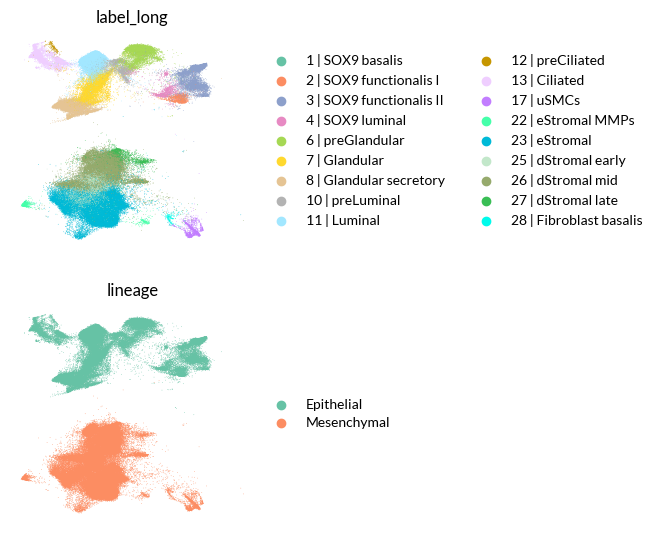

In [24]:
plt.rcParams['figure.figsize'] = (2,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(mt_adata,
                color=['label_long', 'lineage'],
                ncols=1,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                cmap='OrRd',
                save='Markers-celltypes'
               )

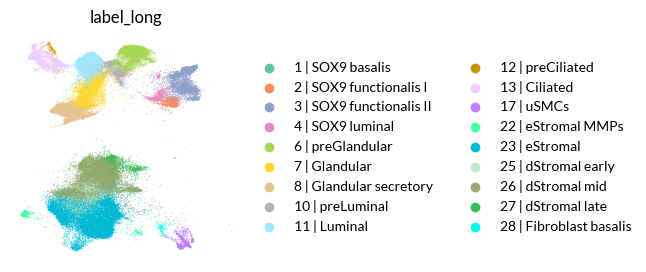

In [25]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(mt_adata,
                color=['label_long'],
                ncols=1,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                cmap='OrRd',
                save='Markers-celltypes-only'
               )

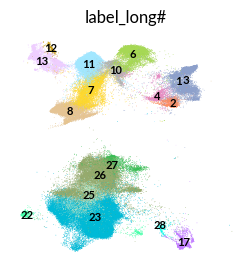

In [26]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

mt_adata.obs[cell_group + '#'] = mt_adata.obs[cell_group].apply(lambda x: x.split(' | ')[0])
sc.pl.embedding(mt_adata,
                color=[cell_group + '#'],
                ncols=1,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                cmap='OrRd',
                legend_loc='on data',
                legend_fontsize=8,
                save='Markers-celltypes-only-Number'
               )

## Metabolic Markers

Detection using TF-IDF

In [27]:
mrks = sccellfie.external.quick_markers(mt_adata,
                                        cluster_key=cell_group, 
                                        n_markers=20, 
                                        express_cut=5*np.log(2)
                                       )

In [28]:
mrks.head()

gene           cluster  \
0      Fructose degradation (to glucose-3-phosphate)  1 | SOX9 basalis   
1                Synthesis of alanine from glutamine  1 | SOX9 basalis   
2  Conversion of 1-phosphatidyl-1D-myo-inositol 4...  1 | SOX9 basalis   
3  ATP generation from glucose (hypoxic condition...  1 | SOX9 basalis   
4            Conversion of carnosine to beta-alanine  1 | SOX9 basalis   

         tf       idf    tf_idf  gene_frequency_outside_cluster  \
0  0.666667  0.688765  0.459177                        0.502184   
1  0.111111  3.349481  0.372165                        0.035097   
2  0.111111  3.199936  0.355548                        0.040760   
3  0.111111  2.374671  0.263852                        0.093044   
4  0.111111  1.337230  0.148581                        0.262583   

   gene_frequency_global  second_best_tf       second_best_cluster      pval  \
0               0.502196        0.868075  3 | SOX9 functionalis II  0.258240   
1               0.035103        0.063319                17 | uSMCs  0.275021   
2               0.040765        0.075924       25 | dStromal early  0.312425   
3               0.093045        0.286517          12 | preCiliated  0.584799   
4               0.262572        0.889733              11 | Luminal  0.935519   

           qval  
0  0.000000e+00  
1  6.091183e-19  
2  1.356023e-57  
3  0.000000e+00  
4  0.000000e+00

<Axes: >

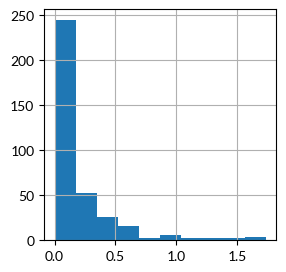

In [29]:
mrks['tf_idf'].hist()

Text(0, 0.5, 'IDF')

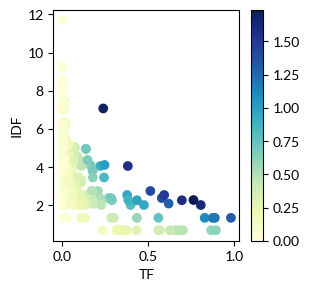

In [30]:
scatter = plt.scatter(mrks['tf'], mrks['idf'], c=mrks['tf_idf'], cmap='YlGnBu')
plt.colorbar(scatter)
plt.xlabel('TF')
plt.ylabel('IDF')

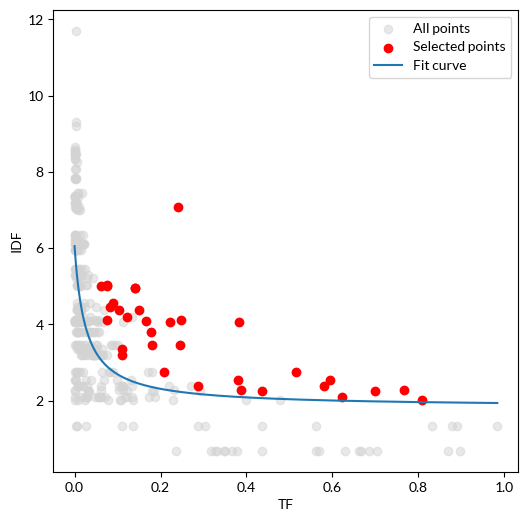

In [31]:
x_col = 'tf'
y_col = 'idf'
df = mrks
tfidf_threshold = 0.3
tf_ratio = 1.2

# Visualization
plt.figure(figsize=(6, 6))

# Plot all points
plt.scatter(df[x_col], df[y_col], alpha=0.5, c='lightgray', label='All points')

# Plot selected points
filtered_mrks, curve = sccellfie.external.filter_tfidf_markers(df, tf_col=x_col, idf_col=y_col, tfidf_threshold=tfidf_threshold, tf_ratio=tf_ratio)

plt.scatter(filtered_mrks[x_col], filtered_mrks[y_col], c='red', label='Selected points')
plt.plot(*curve, label='Fit curve')

plt.xlabel('TF')
plt.ylabel('IDF')
plt.legend()

In [32]:
tf_idf_mrks = filtered_mrks['gene'].unique().tolist()
len(tf_idf_mrks)

24

In [33]:
tf_idf_mrks

['Synthesis of alanine from glutamine',
 'Conversion of 1-phosphatidyl-1D-myo-inositol 4,5-bisphosphate to 1D-myo-inositol 1,4,5-trisphosphate',
 'Presence of the thioredoxin system through the thioredoxin reductase activity',
 'Biosynthesis of Tn_antigen (Glycoprotein N-acetyl-D-galactosamine)',
 'Glucose to lactate conversion',
 'Conversion of estrone (E1) to estrone sulfate (E1S)',
 'ATP generation from glucose (hypoxic conditions) - glycolysis',
 'AMP salvage from adenine',
 "3'-Phospho-5'-adenylyl sulfate synthesis",
 'GMP salvage from guanine',
 'IMP salvage from hypoxanthine',
 'Hydroxymethylglutaryl-CoA synthesis',
 'Synthesis of anthranilate from tryptophan',
 'Phenylalanine to phenylacetaldehyde',
 'Synthesis of L-kynurenine from tryptophan',
 'Synthesis of N-formylanthranilate from tryptophan',
 'Phenylalanine to phenylacetate (via phenylacetaldehyde)',
 'Mevalonate synthesis',
 'Pyridoxal-phosphate synthesis',
 'Synthesis of testosterone from androstenedione',
 'Synthesis o

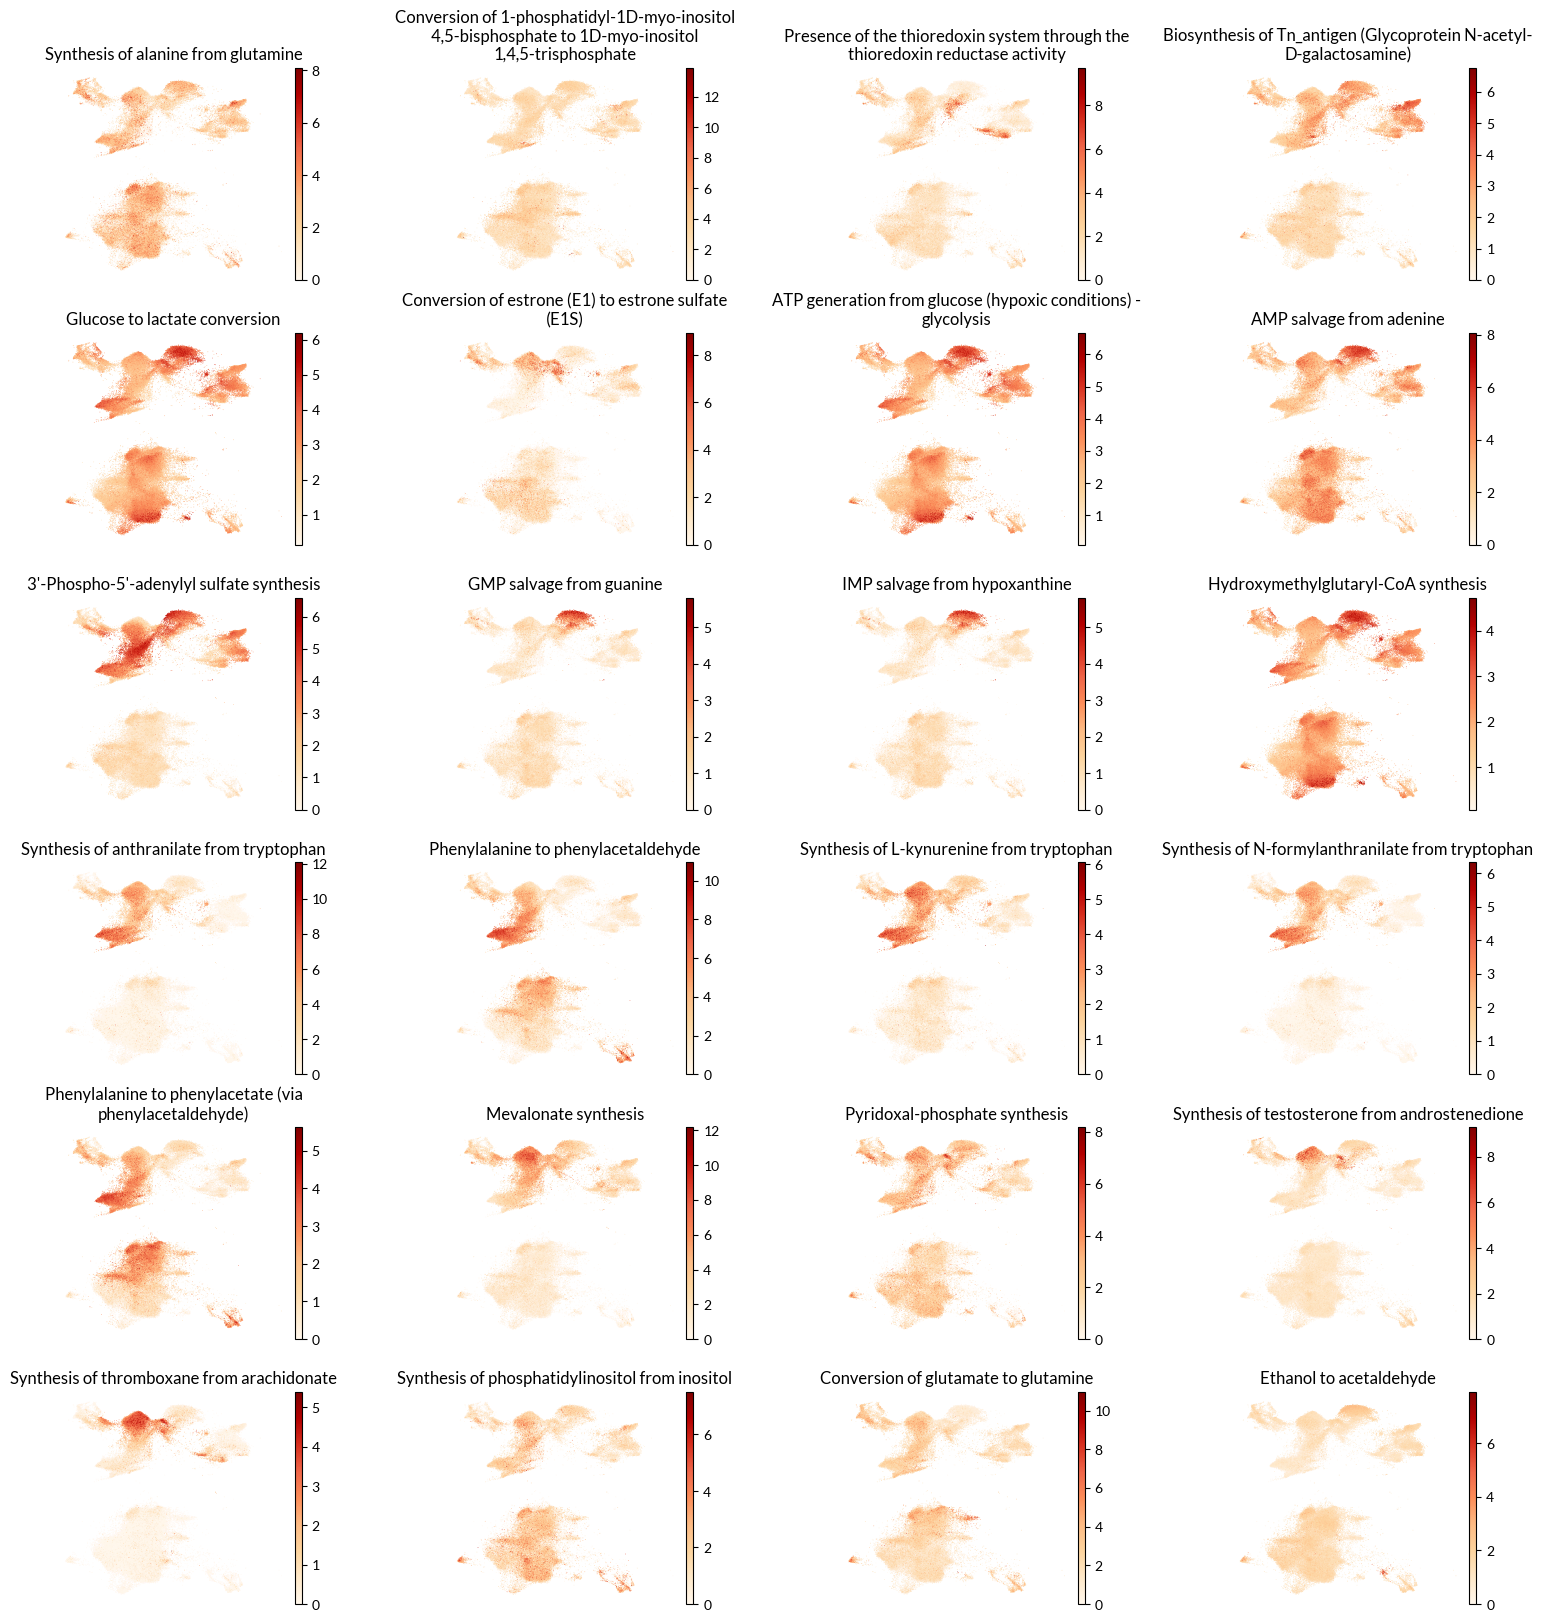

In [34]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(mt_adata,
                color=tf_idf_mrks,
                ncols=4,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.5,
                cmap='OrRd',
                title=["\n".join(textwrap.wrap(t, width=50)) for t in tf_idf_mrks],
                save='Markers-TF-IDF'
               )

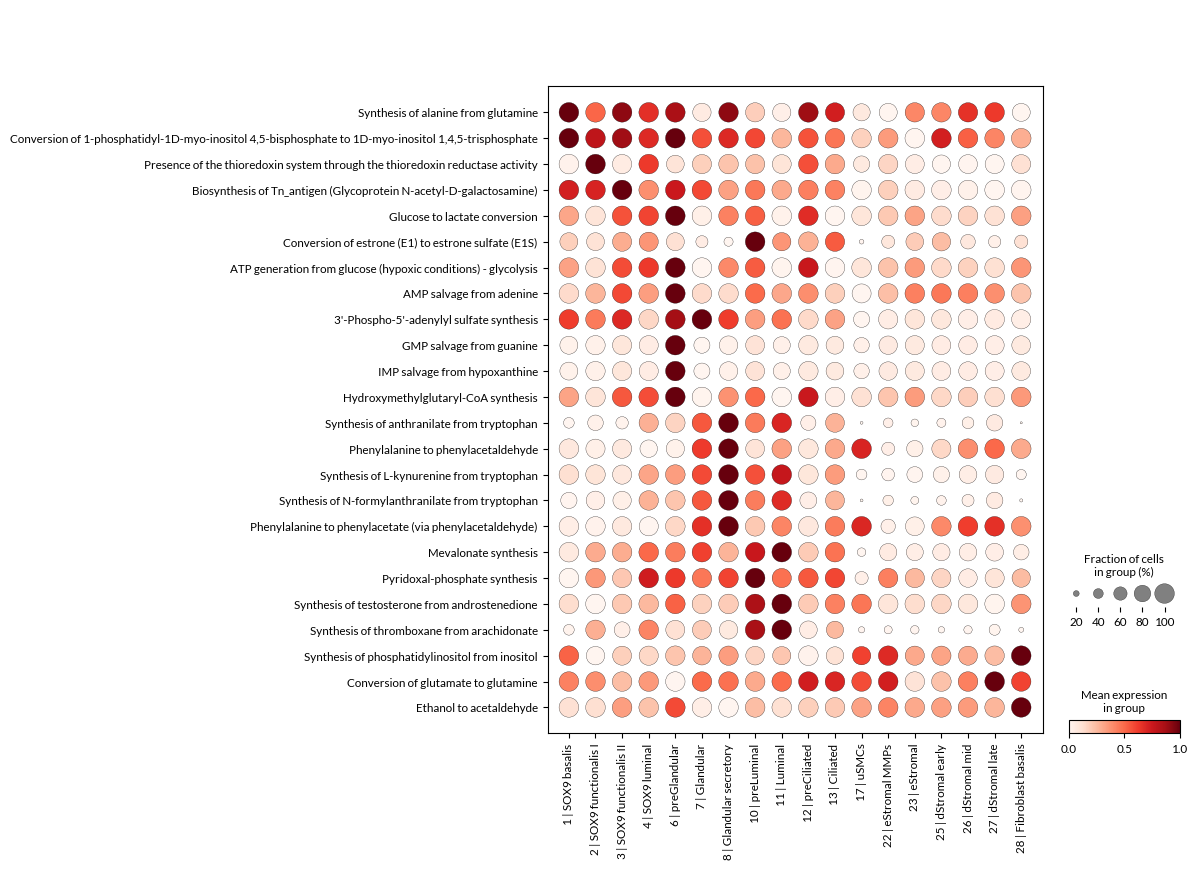

In [35]:
sc.pl.dotplot(mt_adata, tf_idf_mrks, groupby=cell_group, 
              standard_scale='var', 
              swap_axes=True,
              save='Markers-TF-IDF'
              )

Detection using Wilcoxon's test in Scanpy

In [36]:
mt_adata2 = mt_adata[mt_adata.obs['celltype'] != 'dHormones'] # Showing error if used

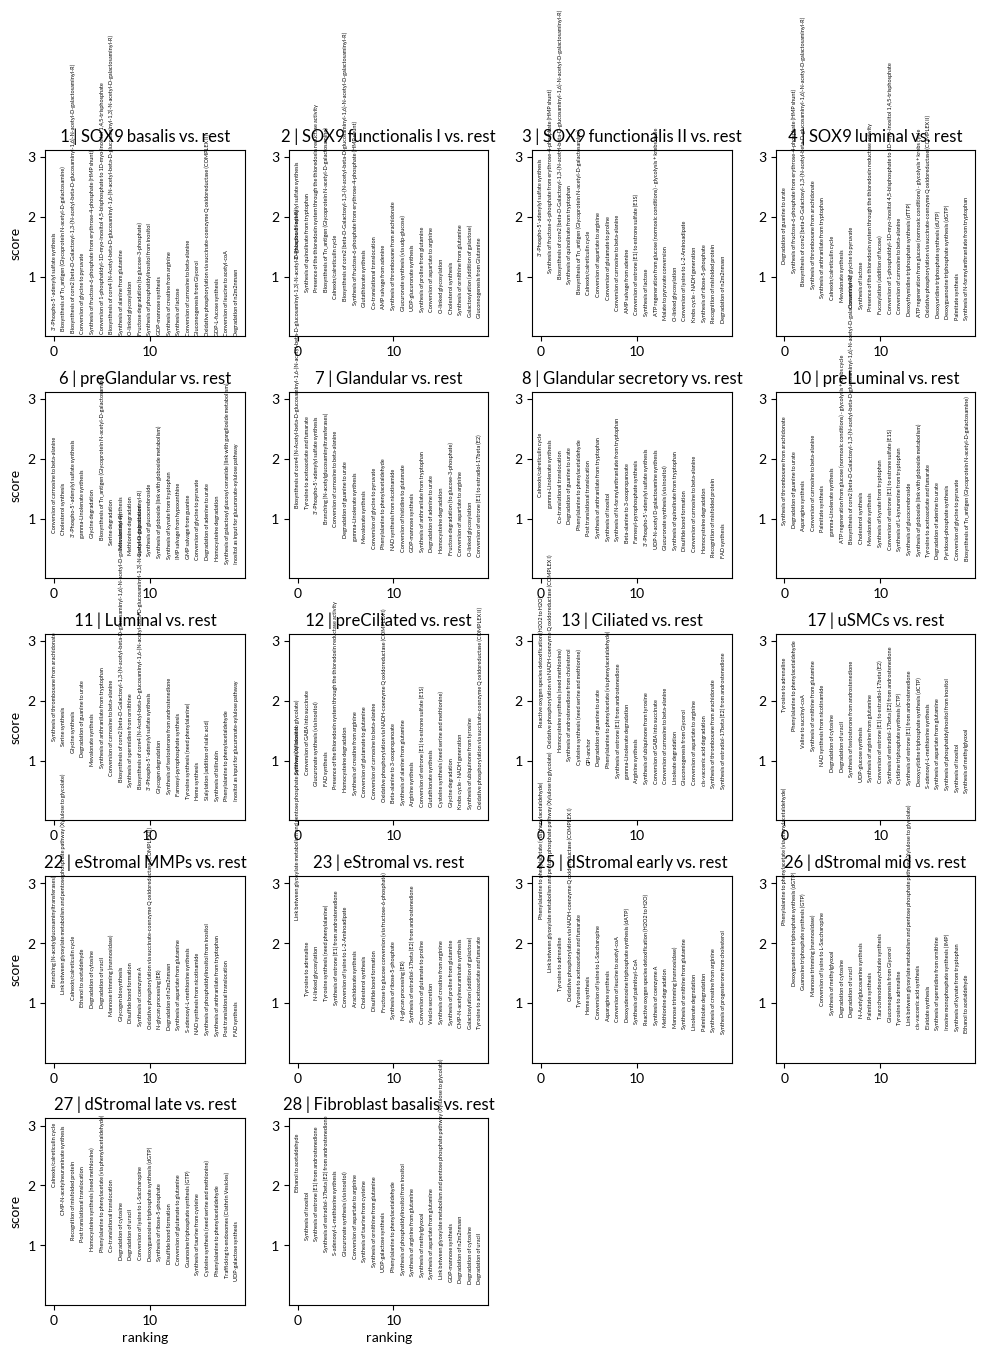

In [37]:
method = 'logreg'
sc.tl.rank_genes_groups(mt_adata2, cell_group, method=method,
                        use_raw=False, key_added = method)

sc.pl.rank_genes_groups(mt_adata2, n_genes=20, sharey=True, key=method, fontsize=4)

In [38]:
scanpy_df = sc.get.rank_genes_groups_df(mt_adata2, 
                                          key=method, 
                                          group=None) 

In [39]:
scanpy_df.sort_values('scores', ascending=False).head(10)

group  \
3010      25 | dStromal early   
2795            23 | eStromal   
3225        26 | dStromal mid   
3440       27 | dStromal late   
3655  28 | Fibroblast basalis   
2365               17 | uSMCs   
2150            13 | Ciliated   
3011      25 | dStromal early   
2366               17 | uSMCs   
3441       27 | dStromal late   

                                                  names    scores  
3010  Phenylalanine to phenylacetate (via phenylacet...  2.401859  
2795  Link between glyoxylate metabolism and pentose...  2.388459  
3225  Phenylalanine to phenylacetate (via phenylacet...  2.312217  
3440                        Calnexin/calreticulin cycle  1.983062  
3655                            Ethanol to acetaldehyde  1.897202  
2365                             Tyrosine to adrenaline  1.830775  
2150  Reactive oxygen species detoxification (H2O2 t...  1.578360  
3011  Link between glyoxylate metabolism and pentose...  1.531857  
2366                Phenylalanine to phenylacetaldehyde  1.509621  
3441                  CMP-N-acetylneuraminate synthesis  1.505134

<Axes: >

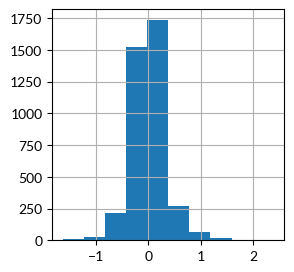

In [40]:
scanpy_df['scores'].hist()

In [41]:
sc_markers_df = scanpy_df
scanpy_markers = sc_markers_df.loc[sc_markers_df['scores'] > 1.5]['names'].unique().tolist()
len(scanpy_markers)

8

In [42]:
scanpy_markers

['Reactive oxygen species detoxification (H2O2 to H2O)',
 'Tyrosine to adrenaline',
 'Phenylalanine to phenylacetaldehyde',
 'Link between glyoxylate metabolism and pentose phosphate pathway (Xylulose to glycolate)',
 'Phenylalanine to phenylacetate (via phenylacetaldehyde)',
 'Calnexin/calreticulin cycle',
 'CMP-N-acetylneuraminate synthesis',
 'Ethanol to acetaldehyde']

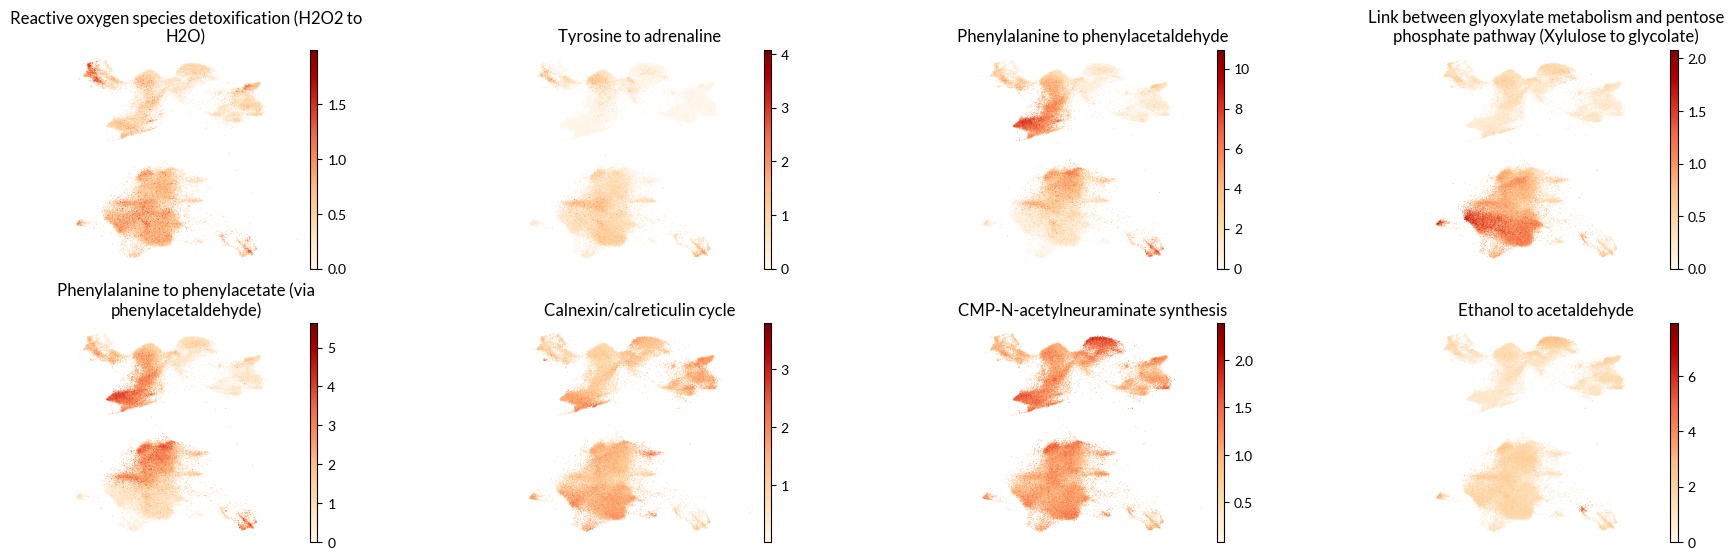

In [43]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(mt_adata,
                color=scanpy_markers,
                ncols=4,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                title=["\n".join(textwrap.wrap(t, width=50)) for t in scanpy_markers],
                cmap='OrRd',
                save='Markers-Scanpy'
               )

## Both Methods Markers

**Sort markers to keep diagonal in plots according to the order of the cell types**

In [44]:
# Collect all markers from both methods to identify overlaps
method1_markers = set(tf_idf_mrks)
method2_markers = set(scanpy_markers)
overlap_markers = method1_markers & method2_markers
method1_only = method1_markers - overlap_markers
method2_only = method2_markers - overlap_markers

# Initialize lists
cat_cells = []
both_markers = []
filtered_mrks['cluster#'] = filtered_mrks['cluster'].apply(lambda x: int(x.split(' | ')[0]))

# Method 1 only markers
for idx, row in filtered_mrks.sort_values(by='cluster#', ascending=True,).iterrows():
    ct_ = row['cluster']
    mkr_ = row['gene']
    if mkr_ in method1_only:  # Only process method1-exclusive markers first
        if (ct_ not in cat_cells) & (ct_ in mt_adata.obs[cell_group].unique()):
            cat_cells.append(ct_)
        if (mkr_ not in both_markers):
            both_markers.append(mkr_)

# Overlapping markers
for idx, row in filtered_mrks.sort_values(by='cluster#', ascending=True,).iterrows():
    ct_ = row['cluster']
    mkr_ = row['gene']
    if mkr_ in overlap_markers:  # Process overlapping markers
        if (ct_ not in cat_cells) & (ct_ in mt_adata.obs[cell_group].unique()):
            cat_cells.append(ct_)
        if (mkr_ not in both_markers):
            both_markers.append(mkr_)

# Method 2 only markers
for idx, row in sc_markers_df.iterrows():
    ct_ = row['group']
    mkr_ = row['names']
    if mkr_ in method2_only:  # Only process method2-exclusive markers
        if (ct_ not in cat_cells) & (ct_ in mt_adata.obs[cell_group].unique()):
            cat_cells.append(ct_)
        if (mkr_ not in both_markers):
            both_markers.append(mkr_)

# Add remaining cell types
for ct_ in mt_adata.obs[cell_group].unique():
    if ct_ not in cat_cells:
        cat_cells.append(ct_)

In [45]:
len(both_markers)

29

In [46]:
#sorted_cells = cat_cells 
sorted_cells = sorted(mt_adata.obs['label_long'].unique(), key=lambda x: int(x.split(' | ')[0]))

In [47]:
agg = sccellfie.expression.aggregation.agg_expression_cells(mt_adata[:, both_markers], 'label_long', agg_func='trimean')
agg = agg.loc[sorted_cells, :]

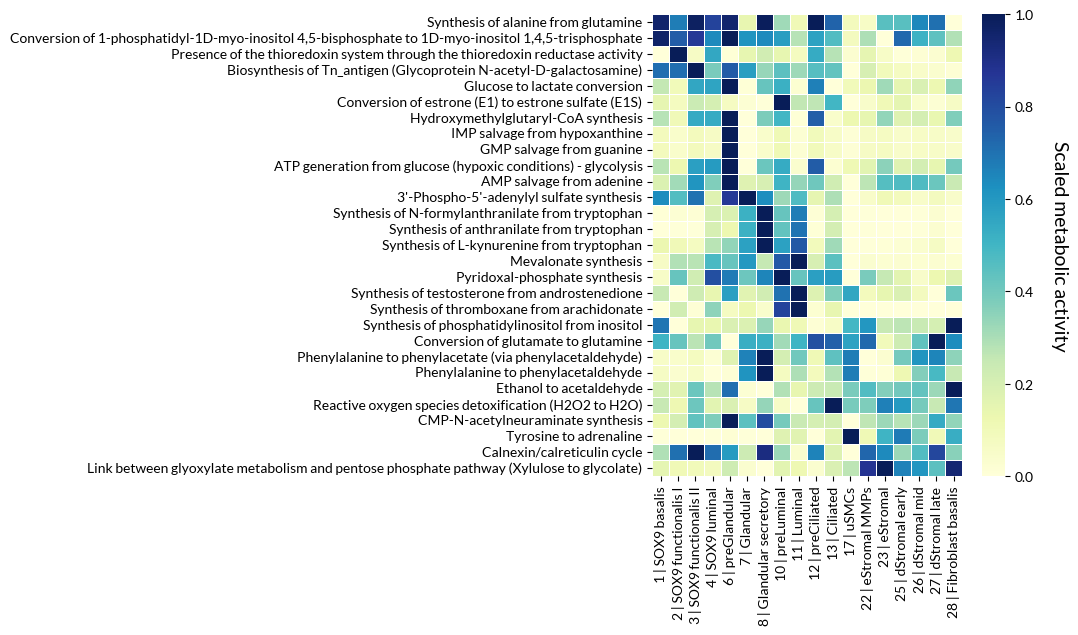

In [48]:
plt.figure(figsize=(5, 6))
input_df = sccellfie.preprocessing.matrix_utils.min_max_normalization(agg.T, axis=1)

g = sns.heatmap(input_df, cmap='YlGnBu', linewidths=0.5, xticklabels=1, yticklabels=1)

cbar = g.collections[0].colorbar
cbar.set_label('Scaled metabolic activity', size=14, rotation=270, labelpad=25)  # Change colorbar label size and rotation
#cbar.ax.tick_params(labelsize=12)  # Change tick label size

plt.savefig('./figures/Heatmap-Both-Markers.pdf', dpi=300, bbox_inches='tight')

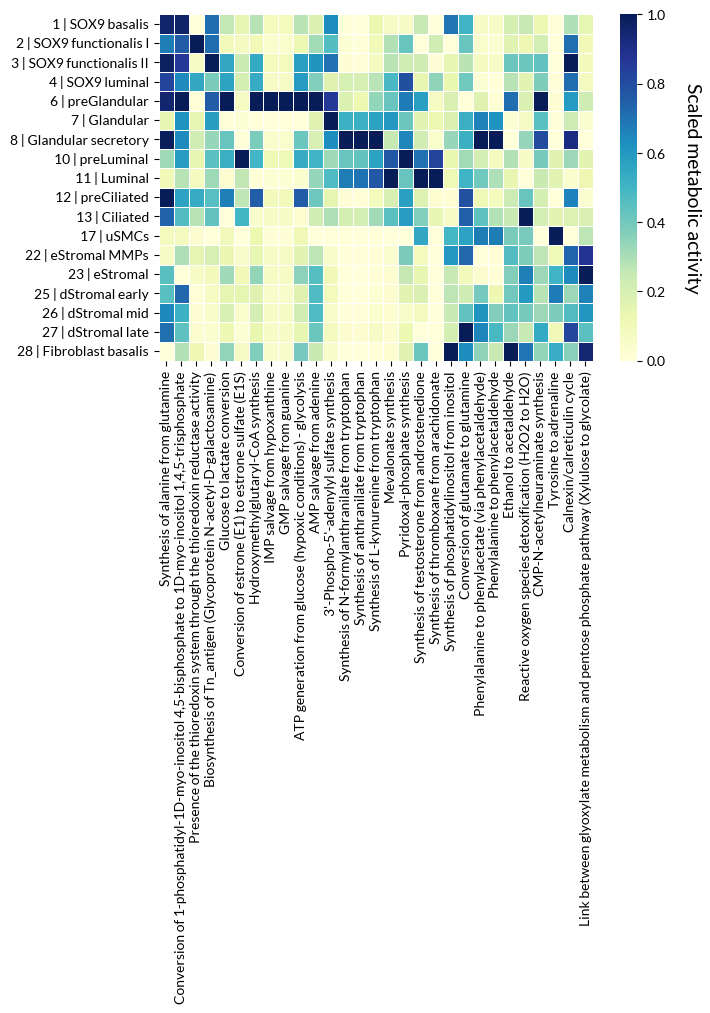

In [49]:
plt.figure(figsize=(7, 4.5))
input_df = sccellfie.preprocessing.matrix_utils.min_max_normalization(agg.T, axis=1)

g = sns.heatmap(input_df.T, cmap='YlGnBu', linewidths=0.5, xticklabels=1, yticklabels=1,
                #cbar_kws={'orientation': 'horizontal',
                #          'pad' : 0.05,
                #          'location' : 'top'
                #         }
               )

cbar = g.collections[0].colorbar
cbar.set_label('Scaled metabolic activity', size=14, rotation=270, labelpad=25)  # Change colorbar label size and rotation
#cbar.ax.tick_params(labelsize=12)  # Change tick label size
#cbar.ax.xaxis.set_ticks_position('bottom')

plt.savefig('./figures/Heatmap-Both-Markers-V2.pdf', dpi=300, bbox_inches='tight')

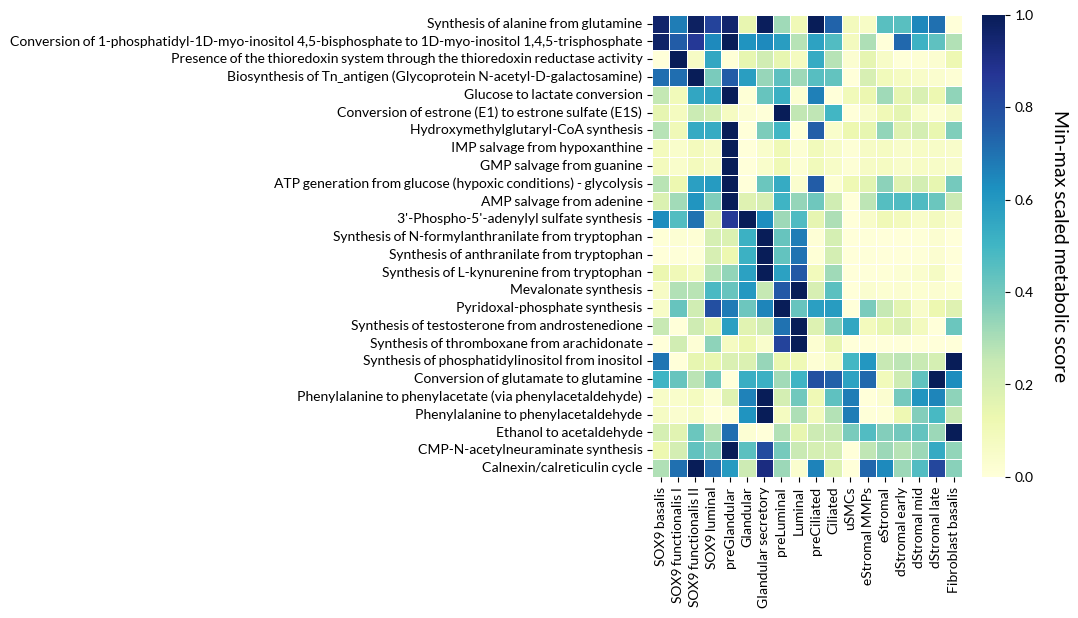

In [50]:
fig, ax = plt.subplots(figsize=(5, 6))
input_df = agg.T.loc[(agg.T > 1.).any(axis=1)] # remove lowly expressed

input_df = sccellfie.preprocessing.matrix_utils.min_max_normalization(input_df, axis=1)

g = sns.heatmap(input_df, cmap='YlGnBu', linewidths=0.5, xticklabels=1, yticklabels=1, ax=ax)
cbar = g.collections[0].colorbar
cbar.set_label('Min-max scaled metabolic score', size=14, rotation=270, labelpad=25)  # Change colorbar label size and rotation

## CHANGE TICKS FOR TASKS
#ax.set_yticklabels(['\n'.join(textwrap.wrap(t, width=60)) for t in input_df.index.tolist()], fontsize=8)
# Get all tick labels
# yticklabels = ax.get_yticklabels()
# # Set alternating colors
# for i, label in enumerate(yticklabels):
#     color = 'black' if i % 2 == 0 else 'dimgrey'
#     label.set_color(color)

xticklabels = ax.get_xticklabels()
ax.set_xticklabels([l.get_text().split(' | ')[1] for l in xticklabels])
    
#cbar.ax.tick_params(labelsize=12)  # Change tick label size
plt.savefig('./figures/Heatmap-Both-Markers-HighExp.pdf', dpi=300, bbox_inches='tight')

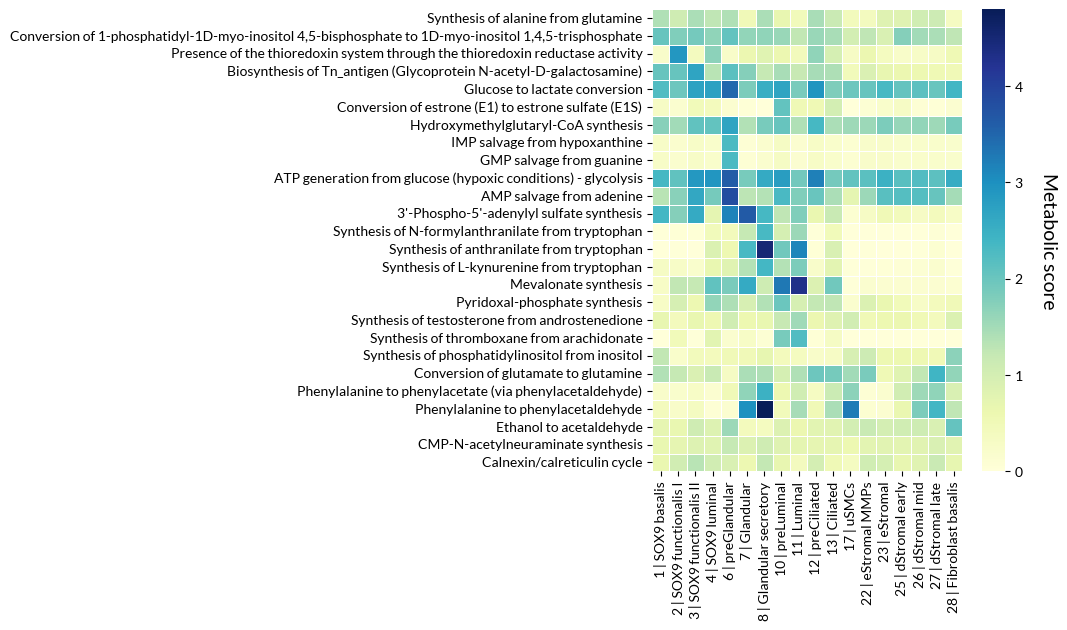

In [51]:
fig, ax = plt.subplots(figsize=(5, 6))
input_df = agg.T.loc[(agg.T > 1.).any(axis=1)] # remove lowly expressed

g = sns.heatmap(input_df, cmap='YlGnBu', linewidths=0.5, xticklabels=1, yticklabels=1, ax=ax)
cbar = g.collections[0].colorbar
cbar.set_label('Metabolic score', size=14, rotation=270, labelpad=25)  # Change colorbar label size and rotation

## CHANGE TICKS FOR TASKS
#ax.set_yticklabels(['\n'.join(textwrap.wrap(t, width=60)) for t in input_df.index.tolist()], fontsize=8)
# Get all tick labels
# yticklabels = ax.get_yticklabels()
# # Set alternating colors
# for i, label in enumerate(yticklabels):
#     color = 'black' if i % 2 == 0 else 'dimgrey'
#     label.set_color(color)
    
#cbar.ax.tick_params(labelsize=12)  # Change tick label size
plt.savefig('./figures/Heatmap-Both-Markers-HighExp-Raw.pdf', dpi=300, bbox_inches='tight')

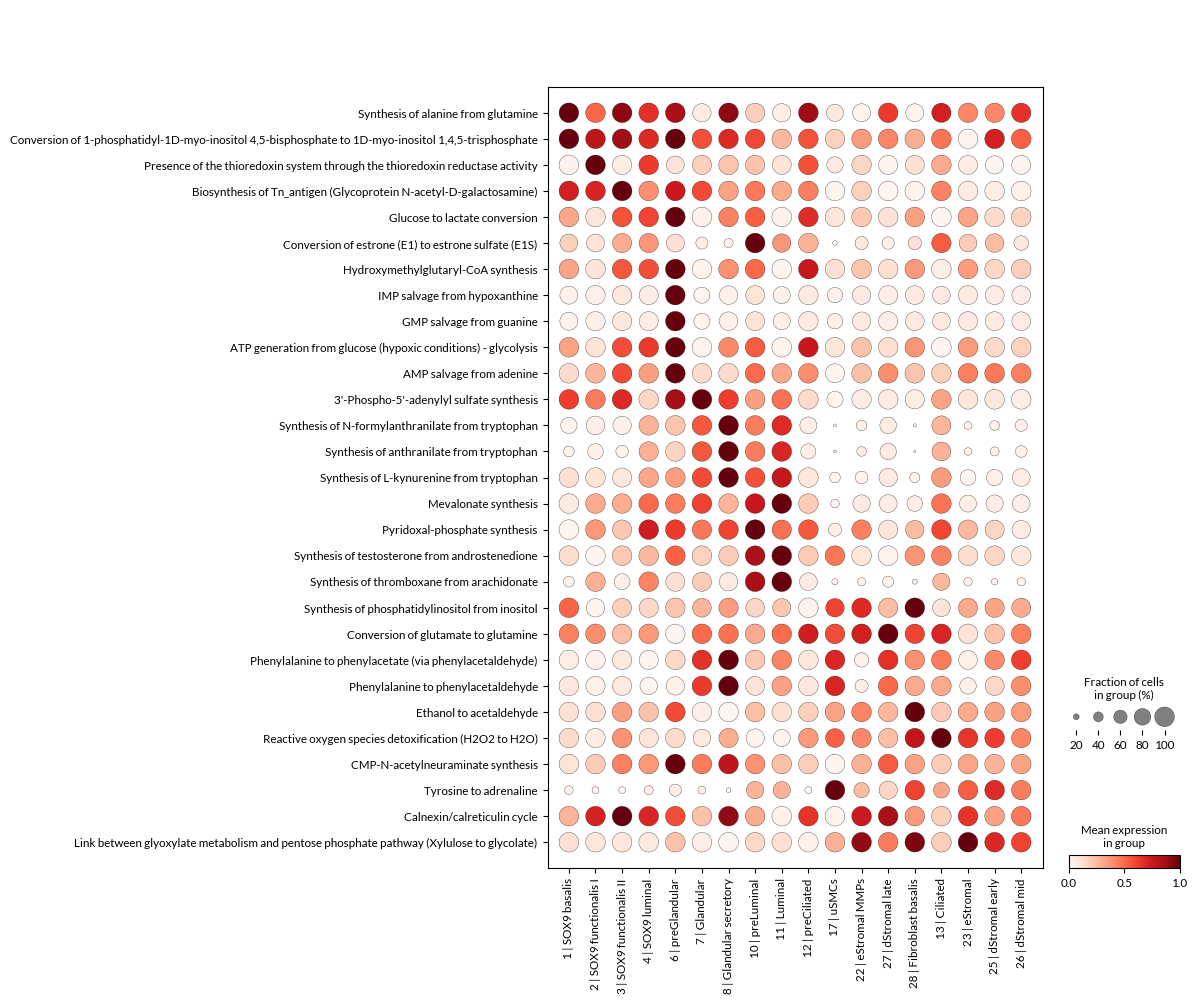

In [52]:
sc.pl.dotplot(mt_adata, both_markers, groupby=cell_group, 
              standard_scale='var', 
              #dendrogram=True,
              swap_axes=True,
              categories_order=cat_cells,
              save='Markers-Both')

In [53]:
both_markers

['Synthesis of alanine from glutamine',
 'Conversion of 1-phosphatidyl-1D-myo-inositol 4,5-bisphosphate to 1D-myo-inositol 1,4,5-trisphosphate',
 'Presence of the thioredoxin system through the thioredoxin reductase activity',
 'Biosynthesis of Tn_antigen (Glycoprotein N-acetyl-D-galactosamine)',
 'Glucose to lactate conversion',
 'Conversion of estrone (E1) to estrone sulfate (E1S)',
 'Hydroxymethylglutaryl-CoA synthesis',
 'IMP salvage from hypoxanthine',
 'GMP salvage from guanine',
 'ATP generation from glucose (hypoxic conditions) - glycolysis',
 'AMP salvage from adenine',
 "3'-Phospho-5'-adenylyl sulfate synthesis",
 'Synthesis of N-formylanthranilate from tryptophan',
 'Synthesis of anthranilate from tryptophan',
 'Synthesis of L-kynurenine from tryptophan',
 'Mevalonate synthesis',
 'Pyridoxal-phosphate synthesis',
 'Synthesis of testosterone from androstenedione',
 'Synthesis of thromboxane from arachidonate',
 'Synthesis of phosphatidylinositol from inositol',
 'Conversion o

In [54]:
input_df.index.tolist()

['Synthesis of alanine from glutamine',
 'Conversion of 1-phosphatidyl-1D-myo-inositol 4,5-bisphosphate to 1D-myo-inositol 1,4,5-trisphosphate',
 'Presence of the thioredoxin system through the thioredoxin reductase activity',
 'Biosynthesis of Tn_antigen (Glycoprotein N-acetyl-D-galactosamine)',
 'Glucose to lactate conversion',
 'Conversion of estrone (E1) to estrone sulfate (E1S)',
 'Hydroxymethylglutaryl-CoA synthesis',
 'IMP salvage from hypoxanthine',
 'GMP salvage from guanine',
 'ATP generation from glucose (hypoxic conditions) - glycolysis',
 'AMP salvage from adenine',
 "3'-Phospho-5'-adenylyl sulfate synthesis",
 'Synthesis of N-formylanthranilate from tryptophan',
 'Synthesis of anthranilate from tryptophan',
 'Synthesis of L-kynurenine from tryptophan',
 'Mevalonate synthesis',
 'Pyridoxal-phosphate synthesis',
 'Synthesis of testosterone from androstenedione',
 'Synthesis of thromboxane from arachidonate',
 'Synthesis of phosphatidylinositol from inositol',
 'Conversion o

## Secretory Machinery

In [55]:
sccellfie_db = sccellfie.datasets.load_sccellfie_database(organism='human')

In [56]:
sec_machinery = ['Processing in the Golgi', 'Processing in the ER', 'Translocation', 'Proteostasis', 'Vesicle trafficking']

In [57]:
sec_tasks = sccellfie_db['task_info'].loc[sccellfie_db['task_info']['System'].isin(sec_machinery)]['Task'].unique().tolist()

In [58]:
sc.tl.score_genes(mt_adata, gene_list=sec_tasks, score_name='Secretory Activity')

In [59]:
for group, df in sccellfie_db['task_info'].loc[sccellfie_db['task_info']['System'].isin(sec_machinery)].groupby('System'):
    group_tasks = df['Task'].unique().tolist()
    sc.tl.score_genes(mt_adata, gene_list=group_tasks, score_name=group)

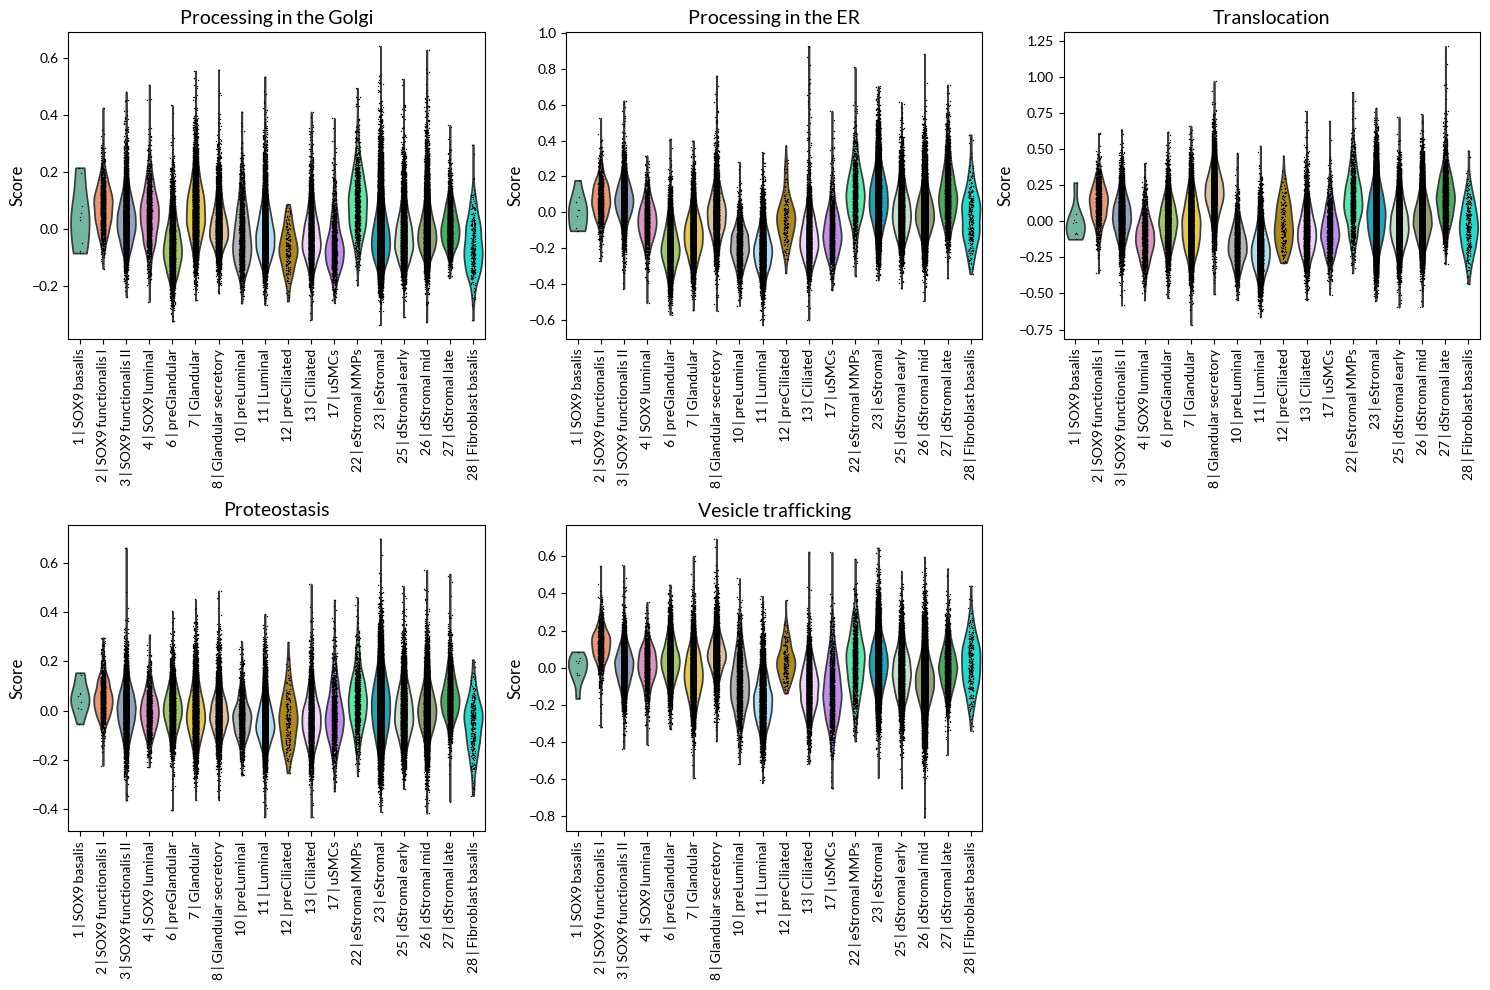

In [60]:
fig, ax = sccellfie.plotting.create_multi_violin_plots(mt_adata[mt_adata.obs.label_long.isin(selected_cells)], 
                                                       features=sec_machinery,
                                                       groupby='label_long',
                                                       n_cols=3,
                                                       ylabel='Score', 
                                                       )

(<Figure size 1500x500 with 1 Axes>,
 array([[<Axes: title={'center': 'Secretory Activity'}, ylabel='Score'>,
         <Axes: >, <Axes: >]], dtype=object))

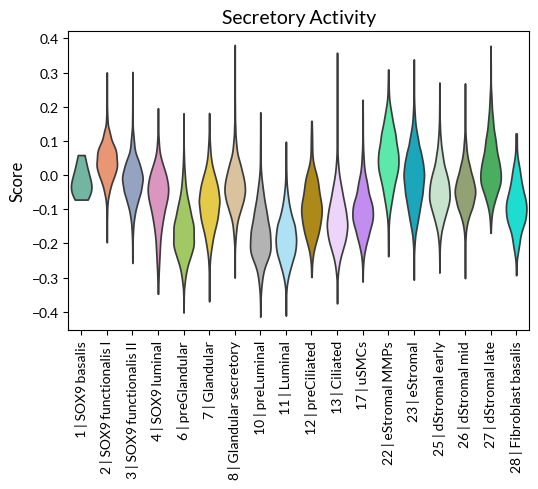

In [61]:
sccellfie.plotting.create_multi_violin_plots(mt_adata[mt_adata.obs.label_long.isin(selected_cells)], 
                                             features=['Secretory Activity'],
                                             groupby='label_long',
                                             n_cols=3,
                                             ylabel='Score',
                                             stripplot=False,
                                             save='Secretory'
                                             )

## Cell-cell communication

In [62]:
adata2 = adata[adata.obs[cell_group].isin(selected_cells)]

In [63]:
adata_update = sccellfie.preprocessing.adata_utils.transfer_variables(mt_adata, adata2,
                                                                      ['TBXA2R', 'AHR']
                                                                     )

In [64]:
ccc_df = sccellfie.communication.traditional_scoring.compute_communication_scores(adata_update, cell_group,
                                                                                  [('Synthesis of thromboxane from arachidonate', 'TBXA2R'),
                                                                                   ('Synthesis of L-kynurenine from tryptophan', 'AHR')
                                                                                  ], ligand_threshold=np.log(2)
                                                                                )

In [65]:
throm = ccc_df.loc[ccc_df.receptor == 'TBXA2R'].sort_values('score', ascending=False).head(10)

In [66]:
throm_thresh = throm.score.mean() + throm.score.std()

In [67]:
filtered_throm = throm.loc[(throm.ligand_fraction > 0.1) & (throm.receptor_fraction > 0.1) & (throm.score >= throm_thresh)]

In [68]:
filtered_throm.shape

(0, 7)

In [69]:
kyn = ccc_df.loc[ccc_df.receptor == 'AHR'].sort_values('score', ascending=False)

In [70]:
### IMPORTANT! THRESHOLD IS ABOVE MEAN + 1 STD
### AND CELL TYPES EXPRESS LIGAND AND RECEPTOR IN MORE THAN 10% OF CELLS
kyn_thresh = kyn.score.mean() + kyn.score.std()

In [71]:
filtered_kyn = kyn.loc[(kyn.ligand_fraction > 0.1) & (kyn.receptor_fraction > 0.1) & (kyn.score >= kyn_thresh)]

In [72]:
filtered_kyn.shape

(55, 7)

In [73]:
prolif = ['1 | SOX9 basalis',
          '2 | SOX9 functionalis I',
          '3 | SOX9 functionalis II',
          '4 | SOX9 luminal',
          '22 | eStromal MMPs',
          '23 | eStromal',
          '12 | preCiliated',
          '13 | Ciliated',
          '28 | Fibroblast basalis',
          '17 | uSMCs',
         ]

early_sec = ['28 | Fibroblast basalis',
             '17 | uSMCs',
             '6 | preGlandular', 
             '3 | SOX9 functionalis II', 
             '25 | dStromal early',
             '10 | preLuminal',
             '13 | Ciliated',
            ]

mid_sec = ['28 | Fibroblast basalis',
           '17 | uSMCs',
           '7 | Glandular',
           '8 | Glandular secretory',
           '26 | dStromal mid',
           '11 | Luminal',
           '13 | Ciliated',
          ]

late_sec = ['28 | Fibroblast basalis',
            '17 | uSMCs',
            '8 | Glandular secretory',
            '27 | dStromal late',
            '11 | Luminal',
            '13 | Ciliated',
           ]

stages = {'Proliferative' : prolif,
          'Secretory early' : early_sec,
          'Secretory mid' : mid_sec,
          'Secretory late' : late_sec
         }

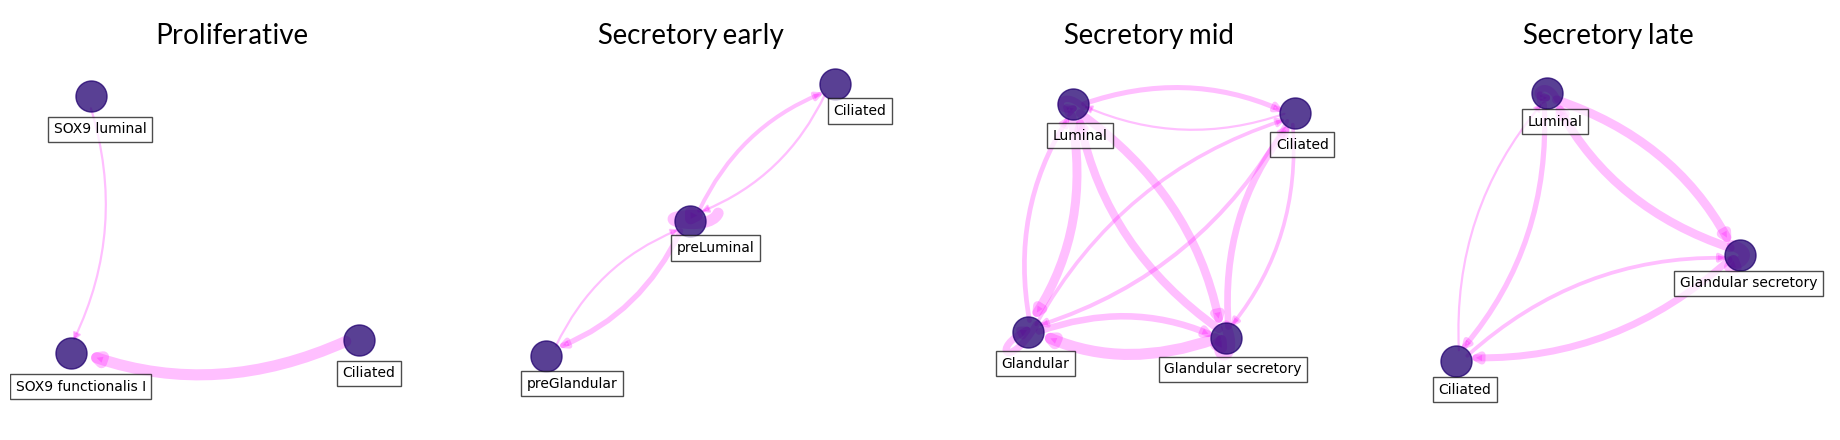

In [74]:
# Multiple subplots
ncols = 4
fig, axes = plt.subplots(int(np.ceil(len(stages))/ncols),
                         ncols, 
                         figsize=(18.5,4.5))


for i, (title, stage ) in enumerate(stages.items()):
    df = filtered_kyn[filtered_kyn.sender_celltype.isin(stage) & filtered_kyn.receiver_celltype.isin(stage)]
    df.sender_celltype = [c.split(' | ')[1] for c in df.sender_celltype]
    df.receiver_celltype = [c.split(' | ')[1] for c in df.receiver_celltype]
    fig, ax = sccellfie.plotting.plot_communication_network(df, 
                                                            'sender_celltype', 
                                                            'receiver_celltype', 
                                                            'score', 
                                                            panel_size=(6,6),
                                                            network_layout='spring',
                                                            edge_color='magenta',
                                                            edge_width=8,
                                                            edge_arrow_size=12,
                                                            edge_alpha=0.25,
                                                            node_color='#210070',
                                                            node_size=500,
                                                            node_alpha=0.75,
                                                            node_label_size=10,
                                                            node_label_alpha=0.7,
                                                            node_label_offset=(0.05, -0.2),
                                                            title=title,
                                                            title_fontsize=20,
                                                            ax=axes.flatten()[i],
                                                            tight_layout=True
                                                           )
plt.savefig('./figures/CCC-SingleCell.pdf', dpi=300, bbox_inches='tight')